In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree

## Load Data

In [ ]:
import random

SEED = np.random.randint(10000)
np.random.seed(SEED)
random.seed(SEED)

In [ ]:
def read_data(test, train):
    X_test = test.drop(columns=['highGrade'])
    labels_test = test['highGrade']

    X_train = train.drop(columns=['highGrade'])
    labels_train = train['highGrade']

    return X_train, X_test, labels_train, labels_test


In [ ]:
df = pd.read_csv('radiomics_features_no_constant.csv')

df_true = df[df['highGrade'] == True]
df_false = df[df['highGrade'] == False]

test_size = int(0.2 * len(df))
half_test_size = test_size // 2

test_true = df_true.sample(n=half_test_size, random_state=42)
test_false = df_false.sample(n=half_test_size, random_state=42)

df_test = ptest_false = df_false.sample(n=half_test_size, random_state=42)

df_test = pd.concat([test_true, test_false])

df_training = df.drop(df_test.index)

print("DATASET TRAINING: ", len(df_training), " REGISTROS")

print("DATASET TESTING: ", len(df_test), " REGISTROS")

DATASET TRAINING:  104  REGISTROS
DATASET TESTING:  24  REGISTROS


In [ ]:
X_train, X_test, labels_train, labels_test = read_data(df_test, df_training)

In [ ]:
print('Fraction of positive labels:', str(round(100*np.mean(labels_train),3)) + '%')

Fraction of positive labels: 83.654%


In [ ]:
def get_precisions_recalls(actual, preds):
    plt.figure(figsize=(16,4))

    plt.subplot(1,2,1)
    precision_0 = np.sum((actual == 0) & (preds == 0)) / np.sum(preds == 0)
    precision_1 = np.sum((actual == 1) & (preds == 1)) / np.sum(preds == 1)

    plt.bar([0,1], [precision_0, precision_1])
    plt.xticks([0,1], ['Class 0', 'Class 1'], fontsize=20)
    plt.yticks(np.arange(0,1.1,0.1), fontsize=14)
    plt.ylabel('Precision', fontsize=20)
    plt.title(f'Precision Class 0: {round(precision_0,2)}\nPrecision Class 1: {round(precision_1,2)}', fontsize=20)

    plt.subplot(1,2,2)
    recall_0 = np.sum((actual == 0) & (preds == 0)) / np.sum(actual == 0)
    recall_1 = np.sum((actual == 1) & (preds == 1)) / np.sum(actual == 1)

    plt.bar([0,1], [recall_0, recall_1])
    plt.xticks([0,1], ['Class 0', 'Class 1'], fontsize=20)
    plt.yticks(np.arange(0,1.1,0.1), fontsize=14)
    plt.ylabel('Recall', fontsize=20)
    plt.title(f'Recall Class 0: {round(recall_0,2)}\nRecall Class 1: {round(recall_1,2)}', fontsize=20)

    plt.tight_layout()
    plt.show()

## Data cleaning

In [ ]:
df = pd.read_csv('flair_df.csv')

# Detectar columnas con un único valor
constant_columns = [col for col in df.columns if df[col].nunique() == 1]

# Mostrar columnas detectadas
print("Columnas con valor constante:")
print(constant_columns)

Columnas con valor constante:
['Unnamed: 0.1', 'Unnamed: 0', 'PyRadiomics/Versions/diagnostics', 'Numpy/Versions/diagnostics', 'SimpleITK/Versions/diagnostics', 'PyWavelet/Versions/diagnostics', 'Python/Versions/diagnostics', 'Settings/Configuration/diagnostics', 'EnabledImageTypes/Configuration/diagnostics', 'Dimensionality/Image-original/diagnostics', 'Minimum/Image-original/diagnostics']


In [ ]:
# Eliminar esas columnas del DataFrame
df_filtered = df.drop(columns=constant_columns)
columns_to_delete = ['Hash/Mask-original/diagnostics', 'Hash/Image-original/diagnostics']
df_filtered = df_filtered.drop(columns=columns_to_delete)

# Guardar dataset limpio (opcional)
df_filtered.to_csv('radiomics_features_no_constant.csv', index=False)

# Confirmar tamaño nuevo del dataset
print(f"Dataset original: {df.shape[1]} columnas")
print(f"Dataset limpio: {df_filtered.shape[1]} columnas")

Dataset original: 135 columnas
Dataset limpio: 122 columnas


In [ ]:
print(list(df_filtered.columns))

['Mean/Image-original/diagnostics', 'Maximum/Image-original/diagnostics', 'VoxelNum/Mask-original/diagnostics', 'VolumeNum/Mask-original/diagnostics', '10Percentile/firstorder/original', '90Percentile/firstorder/original', 'Energy/firstorder/original', 'Entropy/firstorder/original', 'InterquartileRange/firstorder/original', 'Kurtosis/firstorder/original', 'Maximum/firstorder/original', 'MeanAbsoluteDeviation/firstorder/original', 'Mean/firstorder/original', 'Median/firstorder/original', 'Minimum/firstorder/original', 'Range/firstorder/original', 'RobustMeanAbsoluteDeviation/firstorder/original', 'RootMeanSquared/firstorder/original', 'Skewness/firstorder/original', 'TotalEnergy/firstorder/original', 'Uniformity/firstorder/original', 'Variance/firstorder/original', 'Autocorrelation/glcm/original', 'ClusterProminence/glcm/original', 'ClusterShade/glcm/original', 'ClusterTendency/glcm/original', 'Contrast/glcm/original', 'Correlation/glcm/original', 'DifferenceAverage/glcm/original', 'Dif

# Decision Tree

In [ ]:
clf = DecisionTreeClassifier()
clf.fit(X_train, labels_train)
preds = clf.predict(X_test)

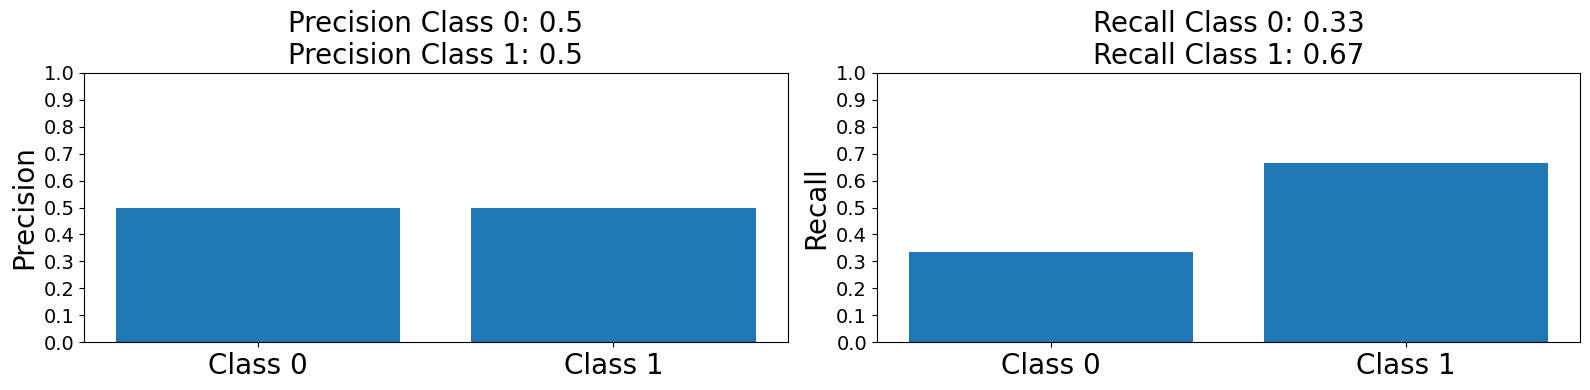

In [ ]:
get_precisions_recalls(labels_test, preds)

# Upweight the minority class

In [ ]:
weight_minority_class = np.sum(labels_train == 1) / np.sum(labels_train == 0)

In [ ]:
weight_minority_class

np.float64(5.117647058823529)

In [ ]:
clf = DecisionTreeClassifier(class_weight={0:1, 1:weight_minority_class})
clf.fit(X_train, labels_train)
preds = clf.predict(X_test)

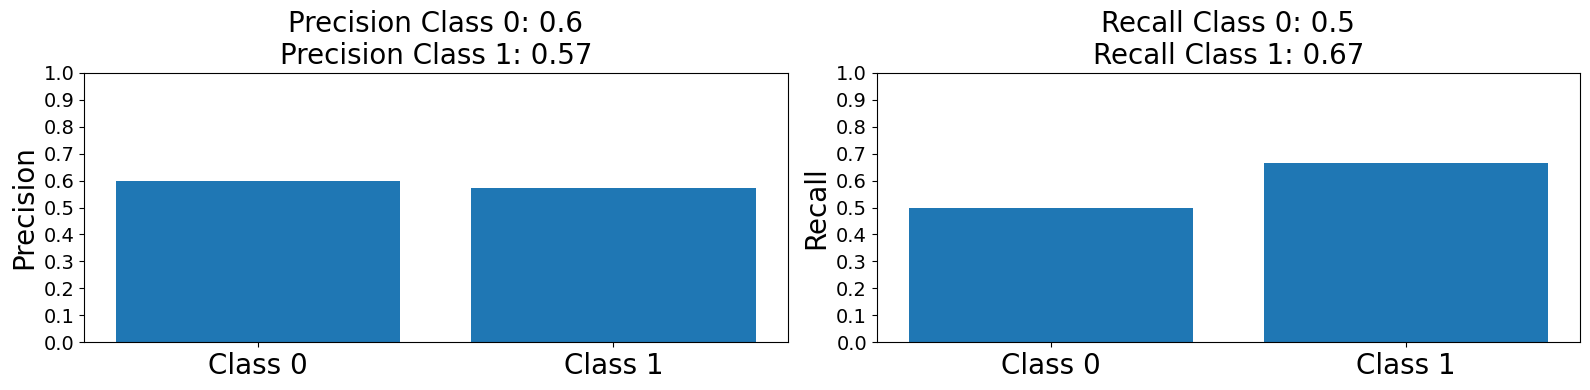

In [ ]:
get_precisions_recalls(labels_test, preds)

# Solution 2: Oversample Minority Class

In [ ]:
indices_0 = df_training[df_training['highGrade'] == False].index
indices_1 = df_training[df_training['highGrade'] == True].index
indices = indices_0.union(indices_1)


weight_minority_class = len(indices_1) / len(indices_0)


weights_0 = pd.Series(weight_minority_class, index=indices_0)
weights_1 = pd.Series(1.0, index=indices_1)
weights = pd.concat([weights_0, weights_1])
weights = weights / weights.sum()  # Normalizar

sampled_indices = np.random.choice(weights.index, size=len(weights), p=weights.values)


df_oversampled = df_training.loc[sampled_indices]


positive_frac = round(100 * df_oversampled['highGrade'].mean(), 3)
print(f'Fraction of positive labels in oversampled data: {positive_frac}%')
df_oversampled.mean()

Fraction of positive labels in oversampled data: 57.692%


,0
Mean/Image-original/diagnostics,52.149036
Maximum/Image-original/diagnostics,600.076923
VoxelNum/Mask-original/diagnostics,4153.173077
VolumeNum/Mask-original/diagnostics,1.019231
10Percentile/firstorder/original,185.530769
...,...
c.CenterOfMassIndex/Mask-original/diagnostics,66.143412
a.CenterOfMass/Mask-original/diagnostics,6.878618
b.CenterOfMass/Mask-original/diagnostics,-5.324829
c.CenterOfMass/Mask-original/diagnostics,15.918170


In [ ]:
X_train_oversampled = df_oversampled.drop(columns=['highGrade'])
labels_train_oversampled = df_oversampled['highGrade']

In [ ]:
clf = DecisionTreeClassifier()
clf.fit(X_train_oversampled, labels_train_oversampled)
preds = clf.predict(X_test)

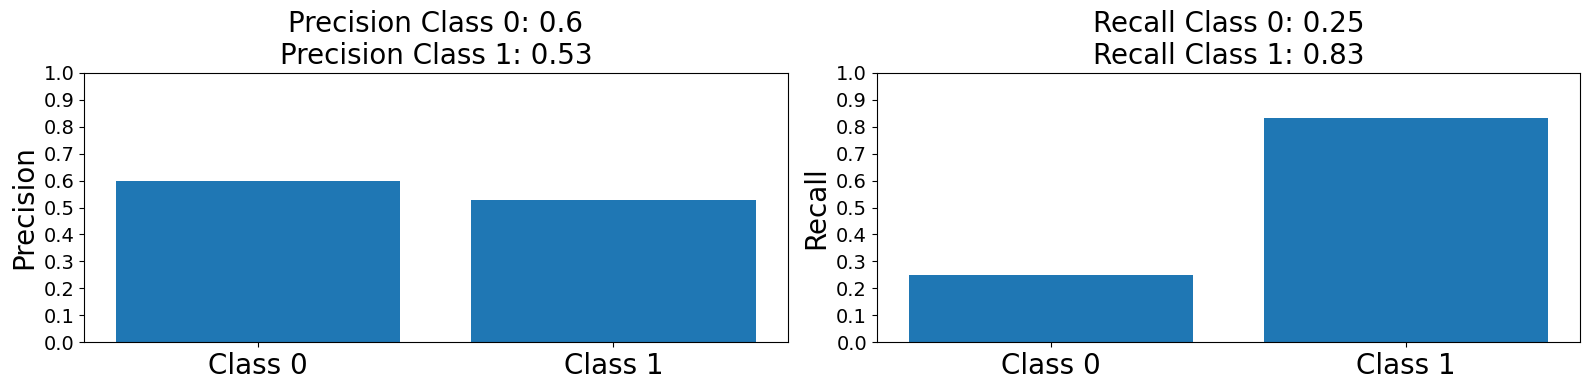

In [ ]:
get_precisions_recalls(labels_test, preds)